In [4]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [5]:
def ACF(data,lags):
    # convert input data into a numpy array
    data = np.array(data)
    # acf will store the autocorreltion coefficent at each lag interval
    # the first datapoint is always 1.0 since anything correlated with itsself is = 1
    acf = [1.0]
    # calculate the mean for the entire dataset
    y_bar = data.mean()
    print("The mean of this dataset is: ",y_bar)
    # subtract the mean from each observation
    yy_bar = data - y_bar
    # clacualte the total variance for the data set
    total_variance = sum(np.square(yy_bar))
    #print("The total variance for this dataset is: ", total_variance)
    # perform a forloop over the dataset with the desired number of lags
    # range is 1,lags b/c the first iteration calcualtes T1
    for i in range(1,lags):
        # first nparray is removing the last element each iteration
        yy_bar_bottom = yy_bar[:-i]
        # second nparray removes the first element each interation
        yy_bar_top = yy_bar[i:]
        # take the sum of of the product of each nparray each iteration
        yy = sum(yy_bar_top * yy_bar_bottom)
        # divide the sum by total variance and append to resulting acf list
        acf.append(yy/total_variance)
    return acf

In [6]:
def acf_plot(y,a):
    #y = y.tolist()
    y_rev = y[::-1]
    y_rev.extend(y[1:])
    print(len(y_rev))
    lb = -(math.floor(len(y_rev)/2))
    hb = -(lb-1)
    x = np.array(list(range(lb,hb)))
    figure = plt.stem(x,y_rev,use_line_collection=True)
    plt.xlabel('Lag', fontsize=15)
    plt.ylabel('AC Coefficent', fontsize=15)
    plt.title('ACF with {} samples'.format(a),fontsize=18)
    plt.show()

    #return y_rev

In [7]:
def GPAC(y,a):
    acf = ACF(y, 30)
    acf_plot(ACF(y, 15),a)
    # construct den matrix
    den = np.zeros([14, 7])
    for j in range(0, 14):
        for k in range(1, 8):
            den[j][k - 1] = acf[abs(j - k + 1)]

    # GPAC matrix
    phikk = np.zeros([7, 7])
    for j in range(0, 7):
        for k in range(0, 7):
            if k == 0:
                d = den[j][k]
                n = den[j + 1][k]
                phi = n / d
                if d < 0.001:
                    phi = 0
                phikk[j][k] = phi
            else:
                d = den[j:j + k + 1, :k + 1]
                # capture the den info for num
                n1 = den[j:j + k + 1, :k]
                # create j+k column
                n2 = np.array(acf[j + 1:j + k + 2])
                num = np.concatenate([n1, n2], axis=1)
                phi = (np.linalg.det(num)) / (np.linalg.det(d))
                dt = (np.linalg.det(d))
                if dt < 0.001:
                    phi = 0
                phikk[j][k] = phi

    # Plot table
    sns.heatmap(phikk, annot=True, vmax=.1, vmin=-.1)
    b, t = plt.ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    plt.ylim(b, t)  # update the ylim(bottom, top) values
    plt.title("GPAC with {} samples".format(a))
    plt.xticks(np.arange(0.5, len(phikk), 1), np.arange(1, 8, 1))
    #plt.show()

In [8]:
def ARMA(N,AR,MA,na,nb):
    # Setup the error signal with N # of samples
    mean = 0
    std = 1
    np.random.seed(42)
    e = std * np.random.randn(N) + mean
    
    print("\nARMA with AR order {0} and MA order {1}".format(AR,MA))
    num = nb
    print("MA",num)
    den = na
    print("AR",den)
    
    system = (num,den,1)
    x,y = signal.dlsim(system,e)
    plt.plot(y)
    plt.show()
    return y

In [9]:
def ARMA_gen():
    a = int(input("\nEnter the numbers of samples :"))
    b = int(input("\nEnter the order # of the AR process :"))
    c = int(input("\nEnter the order # of the MA process :"))
    print("\n The program will ask you to enter each parameter indivdually")
    na = np.zeros(b)
    for i in range(len(na)):
        na[i]= (float(input("\nEnter paramter {0} of AR({1}):".format(i+1,b))))
    if b < c:
        x = np.zeros(c-b)
        na = np.array(list(na) + list(x))
    d = np.array([1] + list(na))
    
    nb = np.zeros(c)
    for  i in range(len(nb)):
        nb[i] = (float(input("\nEnter parameter {0} of MA({1}):".format(i+1,c))))
    if c < b:
        z = np.zeros(b-c)
        nb = np.array(list(nb) + list(z))
    e = np.array([1] + list(nb))
    
    results = ARMA(a,b,c,d,e)
    
    GPAC(results,a)
    
    return results

In [10]:
def step0(num_true,den_true):
    print("\nStep 0:")
    # create the true theta parameters vector based on na,nb parameters
    if len(den_true) == 1:
        theta_true = np.vstack((0,np.vstack(num_true[1:])))
    elif len(num_true) == 1:
        theta_true = np.vstack((np.vstack(den_true[1:]),0))
    else:
        theta_true = np.vstack((np.vstack(den_true[1:]),np.vstack(num_true[1:])))     
    theta_true = [aa for bb in theta_true for aa in bb]
    # Initialize theta vector to zero based on the # of paremeters
    # Revmove the 1 at the begining of num and den since they are for dlsim package and NOT ture parameters
    nb = len(num_true) -1
    na = len(den_true) -1
    # number of parameters
    NP = na + nb
    # intialize parameters to 0 for the length of na + nb
    theta = np.zeros(NP)
    theta = theta.reshape(len(theta),1)
    print("Theta true:", theta_true)
    print("# na parm:",na)
    print("# nb parm:",nb)
    print("Theta shape:",theta.shape)   
    
    return theta_true,theta,na,nb

In [51]:
# Function that takes in theta parameters and y
# Calculates white noise of function y
def calsim(y,theta,na,nb):
    # make sure num and den have same size arrays for dlsim calculations
    pz_num = np.zeros(1)
    pz_den = np.zeros(1)
    if nb < na:
        pz_num = np.zeros(na - nb)
    if na < nb:
        pz_den = np.zeros(nb - na)
    else:
        pz_num = []
        pz_den = []
    #print("\nCalsim:")
    num = [1] + list(theta[na:].flatten()) + list(pz_num)
    den = [1] + list(theta[:na].flatten()) + list(pz_den)
    # reverse order in system 
    system = (den,num,1)
    _,e = signal.dlsim(system,y)
    # Change e from tuple to an array
    enew = np.zeros(len(e))
    for i in range(len(e)):
        enew[i] = e[i][0]
        
    enew = enew.reshape(len(e),1)
    #print("Shape of e: ",enew.shape)
    #print("Length of e: ",len(enew))

    return enew

In [43]:
# Function that calcuates the SSE old
# Creates A and g paramters
def step1(y,theta,delta,na,nb):
    print("Step 1:")
    
    e = calsim(y,theta,na,nb)
    SSEo = float(np.dot(e.T,e))
    X = np.zeros([na+nb,len(e)])
    for i in range(na+nb):
        #print("\n theta {} + delta:".format(i+1))
        theta2 = theta.copy()
        theta2[i] = theta[i] + delta
        e2 = calsim(y,theta2,na,nb)
        X[i] = ((e - e2)/delta).flatten()
        #print("Shape of X:",X.shape)
        
    # Need to transpose the X matrix for the proper shapes    
    X = X.T        
    #print("\nShape of X:",X.shape)
    A = X.T @ X
    #print("\nMatrix A:",A)
    #print("Shape of A:", A.shape)
    g = X.T @ e
    #print("\ng:",g)
    #print("Shape of g:", g.shape)
    
    return A,g,SSEo

In [52]:
# Step 2 update theta
def step2(y,theta,A,g,mu,na,nb):
    print("Step 2:")
    # Create Identity matrix with dimensions NP x NP
    I = np.identity(na+nb)
    #print("\nmu:",mu)
    muI = np.dot(mu,I)
    # Calculate change in theta
    dtheta = np.dot(np.linalg.inv(A + muI),g)
    #print("\nDelta Theta:")
    #print(dtheta)
    #print(dtheta.shape)
    #print("\nTheta old:")
    #print(theta)
    # Add the change in theta to old theta parameters
    thetaNew = np.add(theta,dtheta)
    #print("\nTheta New:")
    #print(thetaNew)
    # Calcualte new error with updated theta parameters
    e3 = calsim(y,thetaNew,na,nb)
    # Calculate new SSE term 
    SSEn = float(np.dot(e3.T,e3))
    # make sure there are no Nan values, make it really big in case
    if math.isnan(SSEn) == True:
        print("SSE = NAN",SSEn)
        SSEn = 9999
    #print("\nSSE New:",SSEn)

    return SSEn,dtheta,thetaNew

In [76]:
# step 3 Convergence
def step3(y,thetaNew,dtheta,SSEn,SSEo,A,g,mu,muf,muMax,delta,na,nb,epsilon,theta_true,theta):
    
    MAX_ITER = 100
    iterations = 0
    SSEs = [SSEo]

    while iterations < MAX_ITER:
        print("\nITERATION:",iterations)
        print("\nSSE New",SSEn,"vs","SSE Old",SSEo)
        SSEs.append(SSEn)
        print("Norm 2:",np.linalg.norm(dtheta,2)," vs Epsilon",epsilon)
        if SSEn < SSEo:
            if np.linalg.norm(dtheta,2) < epsilon:
                print("Reached Convergance")

                theta = thetaNew
                variance_e = SSEn/ (len(y) - (na + nb))
                cov_theta = np.multiply(variance_e,np.linalg.inv(A))

                print("\nEstimated Results:")
                print("\nTotal # of Iterations:", iterations + 1)
                
                CI, THETA = results(theta,na,nb,cov_theta,variance_e,theta_true)
                iterations = np.arange(0, iterations + 2,1).tolist()
                plotSSE(SSEs,iterations)

                return theta, variance_e, cov_theta, SSEs, iterations,CI

            else:
                print("Not Converged")
                theta = thetaNew
                print("mu old:",mu)
                mu /= muf
                print("mu new",mu)

        while SSEn >= SSEo:
            print("mu old:",mu)
            mu *= muf
            print("mu new:",mu)
            if mu > muMax:
                print("ERROR")
                return None
            SSEn, dtheta, thetaNew = step2(y,theta,A,g,mu,na,nb)
    
        iterations += 1

        if iterations > MAX_ITER:
            print("ERROR")

            return None
        
        print("Theta:")
        print(thetaNew)
        theta = thetaNew

        A,g,SSEo = step1(y,theta,delta,na,nb)

        SSEn, dtheta, thetaNew = step2(y,theta,A,g,mu,na,nb)
        

In [77]:
def results(theta,na,nb,cov_theta,variance_e,theta_true):
    # find the std for theta from covariance matrix
    std_theta = np.zeros(len(theta))
    for i in range(len(std_theta)):
        std_theta[i] = np.sqrt(cov_theta[i][i])
        
    # create confidence interval matrix
    confi = np.zeros([len(theta),2])
    for i in range(len(theta)):
        for j in range(len(theta)):
            if j == 0:
                confi[i][j] = theta[i] - (2 * std_theta[i])
            if j == 1:
                confi[i][j] = theta[i] + (2 * std_theta[i])
                
    # Map CI to theta             
    NP = na + nb
    VARS = list(np.zeros(NP))
    for i in range(na):
        VARS[i] = "a" + str(i + 1)
    for i in range(na,NP):
        VARS[i] = "b" + str(i - na + 1)
        
    VARS = np.array(VARS)
    VARS = VARS.reshape(NP,1)
    
    headers = np.array(["Theta"   ," Theta - 2xSTD "," Theta  + 2xSTD  "])
    headers = headers.reshape(1,3)
    
    CI = np.concatenate((VARS,confi),axis = 1)
    CI = np.concatenate((headers,CI,),axis = 0)
    
    THETA = np.concatenate((VARS,theta),axis = 1)
    COV = np.concatenate((VARS,cov_theta),axis = 1)
    
    std_theta = std_theta.reshape(len(std_theta),1)
    STD = np.concatenate((VARS,std_theta),axis = 1)
    
    theta_true = np.array(theta_true)
    theta_true = theta_true.reshape(len(theta_true),1)
    TRUE = np.concatenate((VARS,theta_true),axis = 1)
    
    print("True Theta:")
    print(TRUE)
    print("Estimated Theta:")
    print(THETA)
    print("95% Confidence Interval:")
    print(CI)
    print("Covariance Matrix of Theta:")
    print(COV)
    print("Theta STD:")
    print(STD)
    print("Root Checks:")
    num = [1] + list(theta[na:].flatten())
    den = [1] + list(theta[:na].flatten())
    print("Num(bn):",num)
    print("Den(an):",den)
    print("Roots Num:",np.roots(num))
    print("Roots Den:",np.roots(den))
    print("Variance of Error:")
    print(variance_e)
    print("\nEND")
    
    #df = pd.DataFrame(data=CI)
    
    return CI,THETA

In [78]:
def plotSSE(SSEs,iterations):
    plt.plot(iterations,SSEs)
    plt.title("Iterations vs SSE Decay")
    plt.xlabel("Iterations")
    plt.ylabel("SSE")
    plt.xticks(list(range(0, len(iterations),1)));
    plt.show()

In [79]:
def LM(N,num_true,den_true):
    delta = 1e-6
    mu = 0.1
    muf = 10
    muMax = 10e10
    epsilon = 0.001
    np.random.seed(42)
    mean = 0
    std = 1
    e = std * np.random.randn(N) + mean
    
    # Create the synthetic data to which we want to estimate parameters
    system = (num_true,den_true,1)
    x,y = signal.dlsim(system,e)

    # Step 0 intialize theta
    theta_true,theta, na, nb = step0(num_true,den_true)
    # step1
    A,g,SSEo = step1(y,theta,delta,na,nb)
    # step2
    SSEn, dtheta, thetaNew = step2(y,theta,A,g,mu,na,nb)
    # step3
    theta, variance_e, cov_theta, SSEs, iterations,CI = step3(y,thetaNew,dtheta,SSEn,SSEo,
                                                              A,g,mu,muf,muMax,delta,
                                                              na,nb,epsilon,theta_true,theta)


Step 0:
Theta true: [-0.5, 0.0]
# na parm: 1
# nb parm: 1
Theta shape: (2, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5040.171533854223 vs SSE Old 6509.664692553573
Norm 2: 0.3446723226762567  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[-0.24374754]
 [ 0.24369273]]
Step 1:
Step 2:

ITERATION: 1

SSE New 4963.160672398302 vs SSE Old 5040.171533854223
Norm 2: 0.3426314648128605  vs Epsilon 0.001
Not Converged
mu old: 0.01
mu new 0.001
Theta:
[[-0.48865748]
 [ 0.00407754]]
Step 1:
Step 2:

ITERATION: 2

SSE New 4962.991856506008 vs SSE Old 4963.160672398302
Norm 2: 0.006248147100340559  vs Epsilon 0.001
Not Converged
mu old: 0.001
mu new 0.0001
Theta:
[[-0.48907514]
 [-0.00215663]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4962.991835675422 vs SSE Old 4962.991856506008
Norm 2: 0.0001699099649679625  vs Epsilon 0.001
Reached Convergance

Estimated Results:

Total # of Iterations: 4
True Theta:
[['a1' '-0.5']
 ['b1' '0.0']]
Estimated Theta:
[['a1' '-0.48918626733722703']
 [

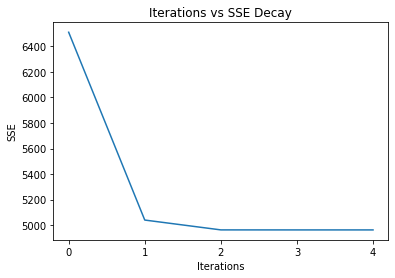

In [80]:
# Example 1 
# 𝑦(𝑡) − 0.5𝑦(𝑡 − 1) = 𝑒(𝑡)
N = 5000
num_true = [1,0]
den_true = [1,-0.5]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.0, 0.5]
# na parm: 1
# nb parm: 1
Theta shape: (2, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5091.663969428766 vs SSE Old 6140.2999525146315
Norm 2: 0.2747060263983874  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[-0.1891704 ]
 [ 0.19919327]]
Step 1:
Step 2:

ITERATION: 1

SSE New 4968.3348745211815 vs SSE Old 5091.663969428766
Norm 2: 0.46833485450259077  vs Epsilon 0.001
Not Converged
mu old: 0.01
mu new 0.001
Theta:
[[0.09198085]
 [0.57374836]]
Step 1:
Step 2:

ITERATION: 2

SSE New 4962.845564389979 vs SSE Old 4968.3348745211815
Norm 2: 0.07568524753822549  vs Epsilon 0.001
Not Converged
mu old: 0.001
mu new 0.0001
Theta:
[[0.03605586]
 [0.52275176]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4962.780263771747 vs SSE Old 4962.845564389979
Norm 2: 0.00870915194856863  vs Epsilon 0.001
Not Converged
mu old: 0.0001
mu new 1e-05
Theta:
[[0.029786  ]
 [0.51670708]]
Step 1:
Step 2:

ITERATION: 4

SSE New 4962.779993259135 vs SSE Old 4962.78026377174

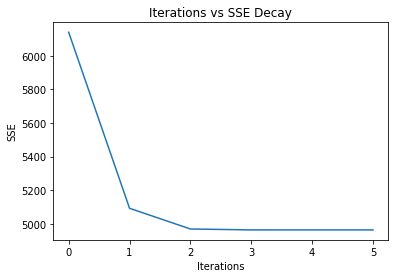

In [81]:
#====Example 2======================== 
# ARMA(0,1) : y(t) = e(t) + 0.5e(t-1)

num_true = [1,0.5]
den_true = [1,0]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.5, -0.5]
# na parm: 1
# nb parm: 1
Theta shape: (2, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5422.465709647698 vs SSE Old 11714.21718084591
Norm 2: 0.5056122441144174  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[ 0.36668856]
 [-0.34811383]]
Step 1:
Step 2:

ITERATION: 1

SSE New 4984.99854224655 vs SSE Old 5422.465709647698
Norm 2: 0.23918016886346347  vs Epsilon 0.001
Not Converged
mu old: 0.01
mu new 0.001
Theta:
[[ 0.43740954]
 [-0.57659949]]
Step 1:
Step 2:

ITERATION: 2

SSE New 4962.997083975841 vs SSE Old 4984.99854224655
Norm 2: 0.08654870308048443  vs Epsilon 0.001
Not Converged
mu old: 0.001
mu new 0.0001
Theta:
[[ 0.49784633]
 [-0.51464731]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4962.98928977142 vs SSE Old 4962.997083975841
Norm 2: 0.001150136483454563  vs Epsilon 0.001
Not Converged
mu old: 0.0001
mu new 1e-05
Theta:
[[ 0.49796054]
 [-0.51350286]]
Step 1:
Step 2:

ITERATION: 4

SSE New 4962.989287853479 vs SSE Old 4962.989289771

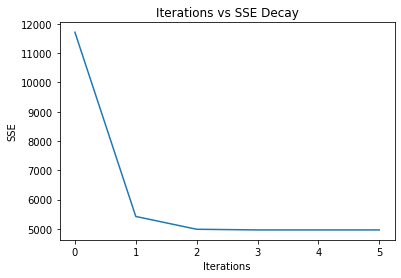

In [82]:
#====Example 3=====================================
# ARMA(1,1) : y(t) + 0.5y(t-1) = e(t) - 0.5e(t-1)

num_true = [1,-0.5]
den_true = [1,0.5]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.5, 0.2, 0.0, 0.0]
# na parm: 2
# nb parm: 2
Theta shape: (4, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5069.219274343834 vs SSE Old 6325.791050786345
Norm 2: 0.39137749748801487  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[ 0.25619528]
 [ 0.10491046]
 [-0.25619521]
 [-0.10439412]]
Step 1:
Step 2:

ITERATION: 1

SSE New 4991.201822285132 vs SSE Old 5069.219274343834
Norm 2: 0.8527368172314004  vs Epsilon 0.001
Not Converged
mu old: 0.01
mu new 0.001
Theta:
[[ 0.84336916]
 [ 0.08369983]
 [ 0.33037719]
 [-0.29899587]]
Step 1:
Step 2:

ITERATION: 2

SSE New 4978.334050079093 vs SSE Old 4991.201822285132
Norm 2: 1.561256892840606  vs Epsilon 0.001
Not Converged
mu old: 0.001
mu new 0.0001
Theta:
[[-0.18658256]
 [ 0.1166257 ]
 [-0.69778238]
 [ 0.2653855 ]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4968.678595575853 vs SSE Old 4978.334050079093
Norm 2: 0.48693826401121304  vs Epsilon 0.001
Not Converged
mu old: 0.0001
mu new 1e-05
Theta:
[[ 0.14198941]

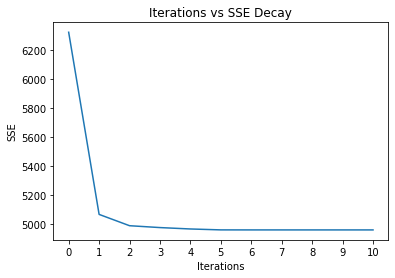

In [83]:
#====Example 4=====================================
# ARMA(2,0) : y(t) + 0.5y(t-1) + 0.2y(t-2) = e(t)
num_true = [1,0,0]
den_true = [1,0.5,0.2]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.5, 0.2, -0.5, 0.0]
# na parm: 2
# nb parm: 2
Theta shape: (4, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5406.166448643157 vs SSE Old 10586.682921342215
Norm 2: 0.7031094364239647  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[ 0.44530417]
 [ 0.21873136]
 [-0.44530412]
 [-0.22344553]]
Step 1:
Step 2:

ITERATION: 1

SSE New 4983.472624311495 vs SSE Old 5406.166448643157
Norm 2: 0.3611648249186841  vs Epsilon 0.001
Not Converged
mu old: 0.01
mu new 0.001
Theta:
[[ 0.75445636]
 [ 0.2202222 ]
 [-0.25859073]
 [-0.22252845]]
Step 1:
Step 2:

ITERATION: 2

SSE New 4963.124286232162 vs SSE Old 4983.472624311495
Norm 2: 0.4289034838915912  vs Epsilon 0.001
Not Converged
mu old: 0.001
mu new 0.0001
Theta:
[[ 0.49656398]
 [ 0.19707194]
 [-0.51438684]
 [ 0.0043683 ]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4962.91239771134 vs SSE Old 4963.124286232162
Norm 2: 0.04586916729568379  vs Epsilon 0.001
Not Converged
mu old: 0.0001
mu new 1e-05
Theta:
[[ 0.52566485

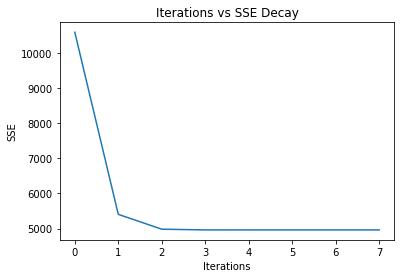

In [31]:
# ====Example 5================================================ 
# ARMA(2,1) : y(t) + 0.5y(t-1) + 0.2y(t-2) = e(t) - 0.5e(t-1)
N = 5000
num_true = [1,-.5,0]
den_true = [1,0.5,0.2]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.5, 0.0, 0.5, -0.4]
# na parm: 2
# nb parm: 2
Theta shape: (4, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5453.912067197486 vs SSE Old 6071.316186590637
Norm 2: 0.22976331054198587  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[ 0.06435523]
 [ 0.15340617]
 [-0.06435501]
 [-0.14482597]]
Step 1:
Step 2:

ITERATION: 1

SSE New inf vs SSE Old 5453.912067197486
Norm 2: 1.0735806870806694  vs Epsilon 0.001
mu old: 0.01
mu new: 0.1
Step 2:
mu old: 0.1
mu new: 1.0
Step 2:
mu old: 1.0
mu new: 10.0
Step 2:
mu old: 10.0
mu new: 100.0
Step 2:
Theta:
[[ 0.42580331]
 [-0.053832  ]
 [ 0.337705  ]
 [-0.43326693]]
Step 1:
Step 2:

ITERATION: 2

SSE New 5.546583787540961e+72 vs SSE Old 5101.057748643105
Norm 2: 0.220729303676957  vs Epsilon 0.001
mu old: 100.0
mu new: 1000.0
Step 2:
Theta:
[[ 0.45722613]
 [-0.07529513]
 [ 0.4435357 ]
 [-0.50180156]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4966.650380343295 vs SSE Old 5002.254690636117
Norm 2: 0.03432619376122632  v

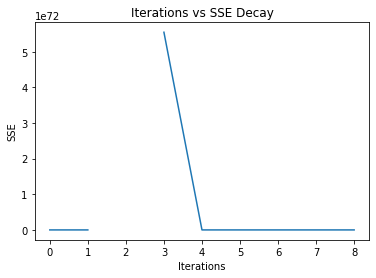

In [84]:
#====Example 6===============================================
# ARMA(1,2) : y(t) + 0.5y(t-1) = e(t) + 0.5e(t-1) - 0.4e(t-2)

num_true = [1,.5,-0.4]
den_true = [1,0.5,0]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.0, 0.0, 0.5, -0.4]
# na parm: 2
# nb parm: 2
Theta shape: (4, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5632.724376717475 vs SSE Old 6986.309387707653
Norm 2: 0.31291244543683716  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[-0.13670491]
 [ 0.17746781]
 [ 0.13670501]
 [-0.17041972]]
Step 1:
Step 2:

ITERATION: 1

SSE New 1.4352063266475607e+42 vs SSE Old 5632.724376717475
Norm 2: 0.6464175973039178  vs Epsilon 0.001
mu old: 0.01
mu new: 0.1
Step 2:
mu old: 0.1
mu new: 1.0
Step 2:
mu old: 1.0
mu new: 10.0
Step 2:
mu old: 10.0
mu new: 100.0
Step 2:
Theta:
[[-0.02008024]
 [-0.12652321]
 [ 0.39302061]
 [-0.53901326]]
Step 1:
Step 2:

ITERATION: 2

SSE New 4962.804368663236 vs SSE Old 5014.778852511634
Norm 2: 0.1336348142102777  vs Epsilon 0.001
Not Converged
mu old: 100.0
mu new 10.0
Theta:
[[-0.0484981 ]
 [-0.02868659]
 [ 0.43865652]
 [-0.46555546]]
Step 1:
Step 2:

ITERATION: 3

SSE New 4962.1352074468805 vs SSE Old 4962.804368663236
Norm 2: 0.

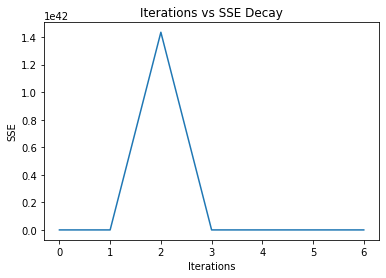

In [85]:
#====Example 7================================================ 
# ARMA(0,2) : y(t) = e(t)+ 0.5e(t-1) - 0.4e(t-2)

num_true = [1,0.5,-0.4]
den_true = [1,0,0]
LM(N,num_true,den_true)


Step 0:
Theta true: [0.5, 0.2, 0.5, -0.4]
# na parm: 2
# nb parm: 2
Theta shape: (4, 1)
Step 1:
Step 2:

ITERATION: 0

SSE New 5739.596287031279 vs SSE Old 7271.517012901601
Norm 2: 0.33930932463912494  vs Epsilon 0.001
Not Converged
mu old: 0.1
mu new 0.01
Theta:
[[ 0.0990159 ]
 [ 0.22467891]
 [-0.09901569]
 [-0.21223089]]
Step 1:
Step 2:
SSE = NAN nan

ITERATION: 1

SSE New 9999 vs SSE Old 5739.596287031279
Norm 2: 1.0485013318762288  vs Epsilon 0.001
mu old: 0.01
mu new: 0.1
Step 2:
SSE = NAN nan
mu old: 0.1
mu new: 1.0
Step 2:
SSE = NAN nan
mu old: 1.0
mu new: 10.0
Step 2:
mu old: 10.0
mu new: 100.0
Step 2:
Theta:
[[ 0.55201837]
 [ 0.05996885]
 [ 0.44547688]
 [-0.544045  ]]
Step 1:
Step 2:

ITERATION: 2

SSE New 5276.088506843139 vs SSE Old 5634.075060741283
Norm 2: 0.05105498120359976  vs Epsilon 0.001
Not Converged
mu old: 100.0
mu new 10.0
Theta:
[[ 0.51645928]
 [ 0.02423969]
 [ 0.44333386]
 [-0.536235  ]]
Step 1:
Step 2:

ITERATION: 3

SSE New 5048.3022945908015 vs SSE Old 527

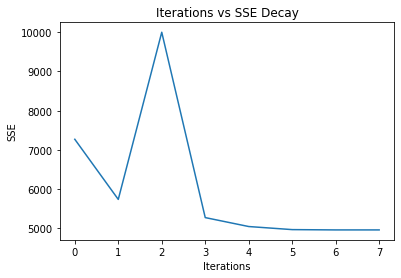

In [86]:
#====Example 8================================================ 
# ARMA(2,2) :y(t)+0.5y(t-1)+0.2y(t-2)=e(t)+0.5e(t-1) - 0.4e(t-2)

num_true = [1,.5,-0.4]
den_true = [1,0.5,0.2]
LM(N,num_true,den_true)